# Predicting Real Estate Prices with a Neural Network (Week 4)

This notebook demonstrates how to build and train a simple neural network for a regression task using the `clownpiece` library. This version incorporates `Dataset`, `Dataloader`, and an `Optimizer`.

Our goal is to predict the price of a house based on a set of features. To do this, we will:
1.  **Generate a synthetic dataset** and save it to CSV files.
2.  **Load the data** using `CSVDataset` and `Dataloader`.
3.  **Define a Multi-Layer Perceptron (MLP)** model using `clownpiece.nn.Sequential`.
4.  **Train the model** using the `SGD` optimizer and `StepLR` scheduler.
5.  **Visualize the training progress** by plotting the loss curve.

In [1]:
import sys
sys.path.append('../../../')

import math
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

from clownpiece import Tensor
from clownpiece.autograd import no_grad
from clownpiece.nn import Module, Linear, Tanh, Sequential, MSELoss, LayerNorm, BatchNorm, LeakyReLU
from clownpiece.utils.data.dataset import CSVDataset
from clownpiece.utils.data.dataloader import Dataloader
from clownpiece.utils.optim.optimizer import SGD
from clownpiece.utils.optim.lr_scheduler import StepLR

### 1. Generating and Saving Synthetic Data

First, we generate our synthetic dataset. After generation, we save the training and test sets into `train.csv` and `test.csv` respectively. This simulates a real-world scenario where data is stored in files.

In [2]:
# Generate synthetic data
np.random.seed(0)
num_train_samples = 2000
num_test_samples = 500

noise_level = 0  # noise level for price generation

# Features: area, house_age, distance_to_city_center, num_convenience_stores, has_yard
def get_features(num_samples):
  area = np.random.uniform(50, 250, (num_samples, 1))  # area in sq meters
  house_age = np.random.uniform(0, 50, (num_samples, 1))  # years
  distance_to_city_center = np.random.uniform(1, 25, (num_samples, 1))  # km
  num_convenience_stores = np.random.randint(0, 11, (num_samples, 1))
  has_yard = np.random.randint(0, 2, (num_samples, 1))
  return np.hstack([area, house_age, distance_to_city_center, num_convenience_stores, has_yard])

# Price is a non-linear combination of features + noise
def get_price(X_raw, noise_level=10):
    area, house_age, distance_to_city_center, num_convenience_stores, has_yard = np.hsplit(X_raw, 5)
    num_samples = X_raw.shape[0]

    # Slightly sublinear area effect (diminishing returns)
    area_term = 10 * (area ** 0.95)

    # House age penalty: mild quadratic
    age_term = -0.5 * (house_age ** 2) + 2.0 * house_age

    # Distance: smooth non-linear decay
    distance_term = -25 * np.sqrt(distance_to_city_center)

    # Convenience stores: log-scale to saturate
    store_term = 6 * np.log1p(num_convenience_stores)

    # Yard bonus (binary)
    yard_term = has_yard * 30.0

    # Interactions
    area_store_interaction = 0.04 * area * np.log1p(num_convenience_stores)
    yard_distance_interaction = -4.0 * has_yard * np.sqrt(distance_to_city_center)
    age_distance_interaction = -0.1 * house_age * distance_to_city_center

    noise = np.random.randn(num_samples, 1) * noise_level

    return (
        100 + area_term + age_term + distance_term +
        store_term + yard_term +
        area_store_interaction + yard_distance_interaction +
        age_distance_interaction + noise
    )

X_train_raw = get_features(num_train_samples)
Y_train_raw = get_price(X_train_raw)
X_test_raw = get_features(num_test_samples)
Y_test_raw = get_price(X_test_raw)

# Save to CSV
if not os.path.exists('data'):
    os.makedirs('data')

with open('data/train.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(np.hstack([X_train_raw, Y_train_raw]))

with open('data/test.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(np.hstack([X_test_raw, Y_test_raw]))

print("Data saved to data/train.csv and data/test.csv")

Data saved to data/train.csv and data/test.csv


### 2. Loading Data with `CSVDataset` and `Dataloader`

Now, we load the data from the CSV files using our custom `CSVDataset`. We also define a transform to process the data on-the-fly. The `Dataloader` will handle batching and shuffling for us.

In [3]:
# Normalization parameters (calculated from the raw training data)
X_mean = X_train_raw.mean(axis=0)
X_std = X_train_raw.std(axis=0)
Y_mean = Y_train_raw.mean(axis=0)
Y_std = Y_train_raw.std(axis=0)

def data_transform(row):
    # Convert string data from CSV to float
    row_float = [float(x) for x in row]
    
    # Separate features and target
    features_raw = np.array(row_float[:-1])
    target_raw = np.array([row_float[-1]])
    
    # Normalize
    features_norm = (features_raw - X_mean) / X_std
    target_norm = (target_raw - Y_mean) / Y_std
    
    # Convert to Tensors
    return Tensor(features_norm.tolist()), Tensor(target_norm.tolist())

# Create Datasets
train_dataset = CSVDataset('data/train.csv', transform=data_transform)
test_dataset = CSVDataset('data/test.csv', transform=data_transform)

# Create Dataloaders
batch_size = 50
train_loader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = Dataloader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Loaded {len(train_dataset)} training samples and {len(test_dataset)} test samples.")

Loaded 2000 training samples and 500 test samples.


### 3. Defining the Model Architecture

We'll use the same MLP architecture as before.

In [4]:
# Define the model
input_features = 5
output_features = 1

model = Sequential(
    Linear(input_features, 32),
    LayerNorm(32),
    Tanh(),
    Linear(32, 16),
    BatchNorm(16),
    LeakyReLU(),
    Linear(16, output_features)
)

print("Model Architecture:")
print(model)

Model Architecture:
Sequential(
 (0): Linear(in_features=5, out_features=32, bias=True)
 (1): LayerNorm(num_features=32, eps=1e-05, affine=True)
 (2): Tanh()
 (3): Linear(in_features=32, out_features=16, bias=True)
 (4): BatchNorm(num_features=16, eps=1e-05, affine=True, momentum=0.1)
 (5): LeakyReLU()
 (6): Linear(in_features=16, out_features=1, bias=True)
)


### 4. Training the Model with an Optimizer

This time, we use the `SGD` optimizer to handle parameter updates and a `StepLR` to schedule the learning rate. The training loop is now cleaner as it iterates through the `Dataloader`.

In [5]:
# Loss, optimizer, and scheduler
loss_fn = MSELoss()
init_lr = 3e-4
epochs = 400

# print("model parameters are ", [_ for _ in model.parameters()])
optimizer = SGD(model.parameters(), lr=init_lr)
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

# Initialize lists to track losses
train_losses = []
test_losses = []

In [6]:
# Training loop
for epoch in range(epochs):
    model.train()
    sum_train_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass
        predictions = model(X_batch)

        # Calculate loss
        loss = loss_fn(predictions, y_batch)
        sum_train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print("para_group ", optimizer.param_groups)
    # print("state is", optimizer.state)
        
    avg_train_loss = sum_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # # Update learning rate
    scheduler.step()
            
    # Evaluate on test set
    model.eval()
    sum_test_loss = 0
    with no_grad():
        for X_batch, y_batch in test_loader:
            test_predictions = model(X_batch)
            sum_test_loss += loss_fn(test_predictions, y_batch).item()
    avg_test_loss = sum_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    if (epoch + 1) % 10 == 0 or epoch < 10:
        print(f"Epoch {epoch+1:3}/{epochs}, train loss: {avg_train_loss:.3f}, test loss: {avg_test_loss:.3f}, lr: {optimizer.param_groups[0]['lr']:.6f}")

[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 1] [50, 32]
[1] [50, 1]
[50, 1] [50, 32]
[50, 

### 5. Visualizing the Results

Finally, we plot the training and test loss over epochs.

Min test loss achieved: 0.021


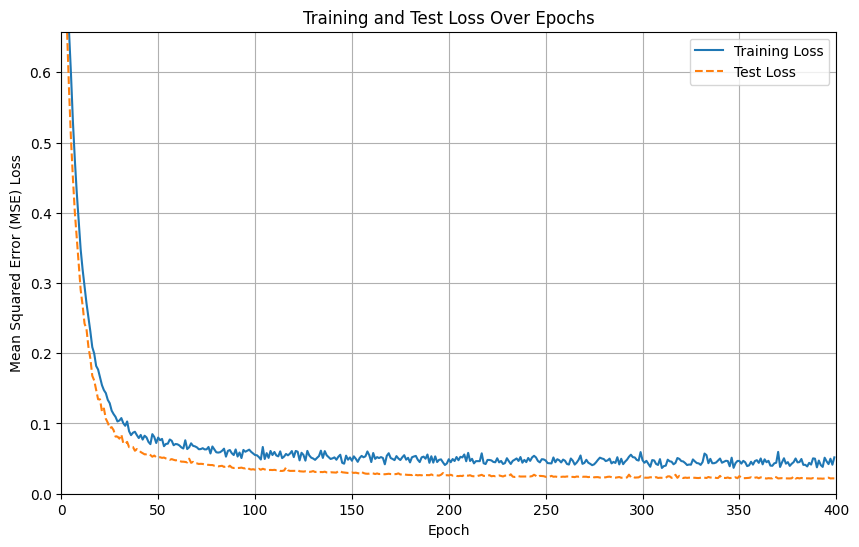

In [7]:
# Visualize Training and Test Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.title("Training and Test Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE) Loss")
plt.xlim(0, epochs)
plt.ylim(0, max(max(train_losses[5:]), max(test_losses[5:])) * 1.1)
print(f"Min test loss achieved: {min(test_losses):.3f}")
plt.legend()
plt.grid(True)
plt.show()